<a href="https://colab.research.google.com/github/svanalex/Bayesian_optimization/blob/main/Extrovert_introvert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/extrovert-vs-introvert-behavior-data


In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Data preprocessing

In [177]:
df = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv")
df.head(10)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
5,1.0,No,7.0,5.0,No,6.0,6.0,Extrovert
6,4.0,No,9.0,NaN,No,7.0,7.0,Extrovert
7,2.0,No,8.0,4.0,No,7.0,8.0,Extrovert
8,10.0,Yes,1.0,3.0,Yes,0.0,3.0,Introvert
9,0.0,No,8.0,6.0,No,13.0,8.0,Extrovert


In [178]:
def toNum(value):
  if(value == 'No' or value == 'Introvert'):
    return 0
  else:
    return 1

In [179]:
df['Stage_fear'] = df['Stage_fear'].apply(toNum)
df['Drained_after_socializing'] = df['Drained_after_socializing'].apply(toNum)
df['Personality'] = df['Personality'].apply(toNum)

In [180]:
#Filling all NaN values with column means
df = df.fillna(df.mean())

##Data exploration

In [181]:
#Checking for NaN values in this dataset
print(df.isna().sum())

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


In [182]:
#Formatting a correlation matrix
df.corr().style.background_gradient(cmap='coolwarm')

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
Time_spent_Alone,1.000000,0.824862,-0.718139,-0.735247,0.839927,-0.701665,-0.718072,-0.712468
Stage_fear,0.824862,1.000000,-0.824045,-0.847535,0.958746,-0.799648,-0.819148,-0.841198
Social_event_attendance,-0.718139,-0.824045,1.000000,0.731941,-0.841099,0.718518,0.727732,0.721520
Going_outside,-0.735247,-0.847535,0.731941,1.000000,-0.860372,0.718327,0.754758,0.739251
Drained_after_socializing,0.839927,0.958746,-0.841099,-0.860372,1.000000,-0.812346,-0.832304,-0.857086
Friends_circle_size,-0.701665,-0.799648,0.718518,0.718327,-0.812346,1.000000,0.690381,0.687203
Post_frequency,-0.718072,-0.819148,0.727732,0.754758,-0.832304,0.690381,1.000000,0.721062
Personality,-0.712468,-0.841198,0.721520,0.739251,-0.857086,0.687203,0.721062,1.000000


<Figure size 2800x2400 with 0 Axes>

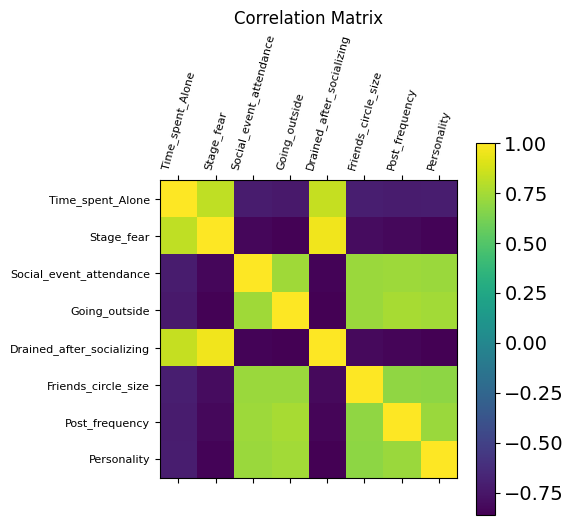

In [183]:
f = plt.figure(figsize=(28, 24))
plt.matshow(df.corr())
plt.xticks(range(df.corr().shape[1]), df.corr().columns, fontsize=8, rotation=75)
plt.yticks(range(df.corr().shape[1]), df.corr().columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=12);

plt.show()

##Machine learning process found below

In [184]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [185]:
features = df.drop(['Personality'], axis=1)
target = df['Personality']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=1/5)

In [186]:
X_train.shape, X_test.shape

((2320, 7), (580, 7))

In [187]:
#We are going to perform bayesian optimization on all models
!pip install bayesian-optimization scikit-learn pandas

In [188]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

###Reusable bayesian optimization function

In [189]:
#Model inspection for targeted feature selection
import inspect

def filter_model_params(model_class, param_dict):
    sig = inspect.signature(model_class.__init__)
    valid_params = sig.parameters
    return {k: v for k, v in param_dict.items() if k in valid_params}


In [190]:
#Function factory allowing reuse of code for bayesian optimization function across models
def make_objective(model_class, X, y, scoring="accuracy", cv=3):
    def objective(**kwargs):
        int_keys = {"max_depth", "min_samples_split", "min_samples_leaf", "n_estimators"}
        for key in int_keys:
            if key in kwargs:
                kwargs[key] = int(kwargs[key])

        if "criterion" in kwargs:
            kwargs["criterion"] = "gini" if kwargs["criterion"] < 0.5 else "entropy"

        if "max_features" in kwargs:
            kwargs["max_features"] = max(kwargs["max_features"], 0.999)
            kwargs["max_features"] = min(kwargs["max_features"], 0.999)

        filtered_params = filter_model_params(model_class, kwargs)

        model = model_class(**filtered_params)
        score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
        return score
    return objective


###Decision Tree

In [191]:
DT_param_bounds = {
    'criterion': (0, 1),
    'max_depth': (5, 20),
    'min_samples_split': (2, 25),
    'min_samples_leaf': (3, 25),
    'max_features': (0, 1),
}

objective_fn = make_objective(DecisionTreeClassifier, X_train, y_train, scoring="accuracy")

optimizer = BayesianOptimization(f=objective_fn, pbounds=DT_param_bounds, random_state=None)
optimizer.maximize(init_points=5, n_iter=15)


|   iter    |  target   | criterion | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | 0.925     | 0.04099   | 17.85     | 0.6101    | 23.81     | 11.33     |
| 2         | 0.928     | 0.1141    | 17.96     | 0.1894    | 22.93     | 2.945     |
| 3         | 0.9345    | 0.9445    | 5.583     | 0.474     | 7.483     | 16.86     |
| 4         | 0.928     | 0.7894    | 15.26     | 0.1891    | 18.81     | 6.069     |
| 5         | 0.925     | 0.6783    | 18.76     | 0.02649   | 23.77     | 7.04      |
| 6         | 0.9345    | 0.0       | 5.0       | 1.0       | 4.04      | 9.805     |
| 7         | 0.9233    | 0.0       | 15.23     | 1.0       | 3.0       | 16.97     |
| 8         | 0.9332    | 1.0       | 5.0       | 0.0       | 11.53     | 10.51     |
| 9         | 0.9306    | 1.0       | 5.0       | 0.0       | 15.15     | 23.76     |
| 10        | 0.9345    | 1.0       | 5.0       | 0.0 

In [192]:
DT_best_params = optimizer.max['params']

###Random Forest Classifier

In [193]:
RF_param_bounds = {
    'n_estimators': (100, 400),
    'criterion': (0, 1),
    'max_depth': (5, 20),
    'min_samples_split': (2, 25),
    'min_samples_leaf': (2, 25),
    'max_features': (0, 1)
}

objective_fn = make_objective(RandomForestClassifier, X_train, y_train, scoring="accuracy")

optimizer = BayesianOptimization(f=objective_fn, pbounds=RF_param_bounds, random_state=None)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | criterion | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.928     | 0.8159    | 12.63     | 0.06562   | 24.77     | 3.733     | 101.6     |
| 2         | 0.928     | 0.385     | 6.34      | 0.2514    | 24.5      | 19.27     | 313.7     |
| 3         | 0.928     | 0.3372    | 9.096     | 0.3562    | 17.2      | 4.989     | 387.5     |
| 4         | 0.9345    | 0.3857    | 15.43     | 0.2142    | 5.637     | 10.15     | 181.7     |
| 5         | 0.9293    | 0.4308    | 18.23     | 0.07706   | 12.76     | 24.59     | 342.2     |
| 6         | 0.9341    | 0.0835    | 15.74     | 0.8105    | 6.573     | 8.157     | 180.6     |
| 7         | 0.9341    | 1.0       | 14.3      | 0.0       | 2.174     | 21.72     | 205.0     |
| 8         | 0.9345    | 1.0       | 5.0       | 0.0       | 2.0       | 25.0      | 168.4     |
| 9         | 0.928 

In [194]:
RF_best_params = optimizer.max['params']

In [195]:
print(RF_best_params)

{'criterion': np.float64(0.3857065508323365), 'max_depth': np.float64(15.427361933808948), 'max_features': np.float64(0.21423493163382412), 'min_samples_leaf': np.float64(5.637373539111231), 'min_samples_split': np.float64(10.149830150998005), 'n_estimators': np.float64(181.65948879886335)}


Okay this baysian model works well against seen data, but does overfit quite a bit

###XGBoost

In [196]:
XGB_param_bounds = {
    'n_estimators': (10, 200),
    'max_depth': (1, 20),
    'learning_rate': (0.01, 0.5)
}

objective_fn = make_objective(xgb.XGBClassifier, X_train, y_train, scoring="accuracy")

optimizer = BayesianOptimization(f=objective_fn, pbounds=XGB_param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.9185    | 0.1935    | 19.06     | 149.1     |
| 2         | 0.9185    | 0.3033    | 3.964     | 39.64     |
| 3         | 0.9185    | 0.03846   | 17.46     | 124.2     |
| 4         | 0.9185    | 0.357     | 1.391     | 194.3     |
| 5         | 0.9185    | 0.4179    | 5.034     | 44.55     |
| 6         | 0.9185    | 0.2105    | 19.84     | 10.16     |
| 7         | 0.9185    | 0.06265   | 19.94     | 199.9     |
| 8         | 0.9185    | 0.1694    | 10.1      | 37.13     |
| 9         | 0.9185    | 0.4592    | 2.409     | 199.9     |
| 10        | 0.9185    | 0.4481    | 17.37     | 88.51     |
| 11        | 0.9185    | 0.1137    | 1.158     | 10.71     |
| 12        | 0.9185    | 0.1764    | 1.617     | 199.8     |
| 13        | 0.9185    | 0.1708    | 1.353     | 10.3      |
| 14        | 0.9185    | 0.3091    | 5.208     | 195.5     |
| 15    

In [197]:
XG_best_params = optimizer.max['params']

##Final evaluation of models
To include table with accuracy, precision, and recall scores

Additionally figure with all confusion matrices

In [198]:
dt_model = DecisionTreeClassifier(
    criterion= 'gini' if DT_best_params['criterion'] < 0.5 else 'entropy',
    max_depth=int(DT_best_params['max_depth']),
    max_features=DT_best_params['max_features'],
    min_samples_leaf=int(DT_best_params['min_samples_leaf']),
    min_samples_split=int(DT_best_params['min_samples_split']),
)
dt_model.fit(X_train, y_train)
dtscore = dt_model.score(X_test, y_test)
print(dt_model.score(X_train, y_train))
print(dt_model.score(X_test, y_test))
dt_pred = dt_model.predict(X_test)


0.9336206896551724
0.9327586206896552


In [199]:
print(DT_best_params)
print(RF_best_params)

{'criterion': np.float64(0.9444657180425852), 'max_depth': np.float64(5.582715257505028), 'max_features': np.float64(0.4740043606399621), 'min_samples_leaf': np.float64(7.4831836997643055), 'min_samples_split': np.float64(16.864533493447368)}
{'criterion': np.float64(0.3857065508323365), 'max_depth': np.float64(15.427361933808948), 'max_features': np.float64(0.21423493163382412), 'min_samples_leaf': np.float64(5.637373539111231), 'min_samples_split': np.float64(10.149830150998005), 'n_estimators': np.float64(181.65948879886335)}


In [200]:
rf_model = RandomForestClassifier(
    criterion= 'gini' if RF_best_params['criterion'] < 0.5 else 'entropy',
    max_depth=int(RF_best_params['max_depth']),
    max_features=RF_best_params['max_features'],
    min_samples_leaf=int(RF_best_params['min_samples_leaf']),
    min_samples_split=int(RF_best_params['min_samples_split']),
    n_estimators=int(RF_best_params['n_estimators']),
    random_state=42
)
rf_model.fit(X_train, y_train)
rfscore = rf_model.score(X_test, y_test)
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))
rf_pred = rf_model.predict(X_test)

0.9344827586206896
0.9344827586206896


In [201]:
xgb_model = xgb.XGBClassifier(learning_rate=XG_best_params['learning_rate'],
                              max_depth=int(XG_best_params['max_depth']),
                              n_estimators=int(XG_best_params['n_estimators']))
xgb_model.fit(X_train, y_train)
xgbscore = xgb_model.score(X_test, y_test)
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))
xgb_pred = xgb_model.predict(X_test)

0.9818965517241379
0.8982758620689655


In [202]:
from sklearn.metrics import confusion_matrix

In [204]:
dt_cm = confusion_matrix(y_test, dt_pred)
rf_cm = confusion_matrix(y_test, rf_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)

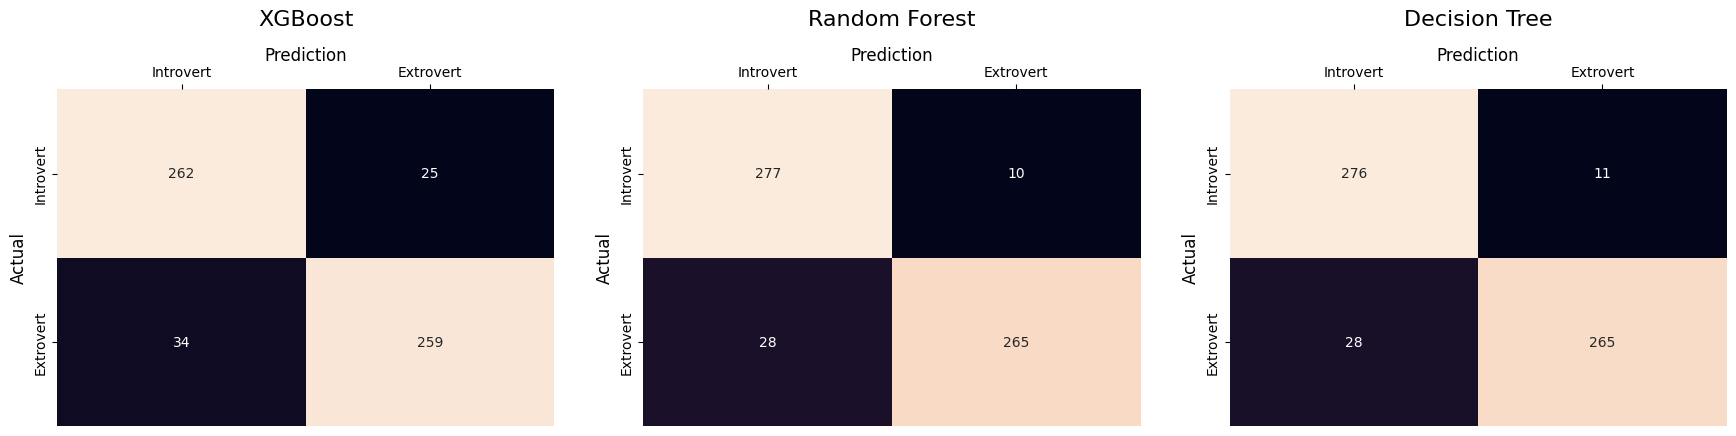

In [214]:
conf_matrices = [
    ('XGBoost', xgb_cm),
    ('Random Forest', rf_cm),
    ('Decision Tree', dt_cm)
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, (title, cm) in zip(axes, conf_matrices):
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Introvert', 'Extrovert'],
                yticklabels=['Introvert', 'Extrovert'],
                ax=ax,
                cbar=False)
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

plt.tight_layout(pad=3.0)
plt.show()
